# ALS BL 5.3.1 Commissioning with bluesky & finch

## Overview 

__Project:__ BL531 Commissioning

__Version:__ 2025-06-27

__Contributors:__
- awojdyla@lbl.gov
- francisho@lbl.gov
- jmchen@lbl.gov
- seijdeleon@lbl.gov
- gabrielgazolla@lbl.gov

__Description:__

This notebook documents the commissioning of BL531 using the Bluesky framework and Pilatus detector. Key steps include:

- Connect the beamline motors, the beamstop diode, and the Pilatus detector using Bluesky. 
- Conduct beamstop scans, sample stage scans, collecting signals with Pilatus and/or diode. 
- Conduct energy (mono) scans, ollecting signals with diode. 

Also in a notebook aside (as we need a different env): 
- Operate the beamline with Finch: import tiled. 

## Set Up

### Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
import hdf5plugin   # For compression support

import time 
from time import sleep as time_sleep

import os
from datetime import datetime

In [5]:
import epics
import bluesky

from bluesky import RunEngine
RE = RunEngine({})

In [6]:
from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

0

### Connect motors and diode

In [7]:
# Connect to EPICS motors and signals

import ophyd
from ophyd import EpicsMotor, EpicsSignal

ophyd.set_cl('caproto')

mono_angle_deg = ophyd.EpicsMotor('bl531_xps1:mono_angle_deg', name='mono angle [deg]')
beamstop_diode = ophyd.EpicsSignal('bl201-beamstop:current', name='beamstop diode')
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Test connections and readbacks
mono_angle_deg.wait_for_connection(timeout=2.0)
print(mono_angle_deg.read())
beamstop_diode.wait_for_connection(timeout=2.0)
print(beamstop_diode.read())

OrderedDict([('mono angle [deg]', {'value': 25.199, 'timestamp': 1751326056.263394}), ('mono angle [deg]_user_setpoint', {'value': 25.198815452865393, 'timestamp': 1751326069.4679542})])
{'beamstop diode': {'value': -766.9, 'timestamp': 1751326068.989605}}


In [8]:
# Import Bluesky plans

from bluesky.plans import scan, count, list_scan, grid_scan 

#### Comments: Interuptions of scans

https://blueskyproject.io/bluesky/main/state-machine.html

On terminal
- __Pause Now: Ctrl+C twice__
- __Pause Soon: Ctrl+C once__

On this notebook: manually interupt (__ONLY ABLE TO PAUSE SOON__)

Results:
```
RunEngineInterrupted:
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:
RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.
```

To check if the scan is ‘paused’ or ‘idle’, ask: 
```
RE.state
```

### Set up mono -> energy


In [9]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
# Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
# Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))

In [10]:
# Test: print current energy

current_mono = epics.caget('bl531_xps1:mono_angle_deg')
current_energy = np.round(energy_eV(current_mono), 1)
print(f'Current energy: {current_energy} eV')

Current energy: 9200.0 eV


### Connect and configure Pilatus detector

In [8]:
# Connect to Pilatus detector

import ophyd
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s


In [9]:
# Custom live table callback for Pilatus

from bluesky.callbacks import CallbackBase

class DetectorLiveTable(CallbackBase):
    """
    Live table showing scan progress with motor positions and HDF5 file info.
    
    Features:
    - Real-time display of scan points and motor positions
    - Automatic filename detection from detector IOC
    - Global variables for easy data analysis access
    - Works with both RE.subscribe() and RE(plan, callback) syntax
    """
    
    def __init__(self, detector, motor_names=None):
        """
        Initialize the live table.
        
        Parameters:
        -----------
        detector : ophyd.Device
            The detector device to monitor
        motor_names : dict, optional
            Custom motor names mapping, e.g. {'x': 'custom_x_name', 'y': 'custom_y_name'}
        """
        super().__init__()  # Important for CallbackBase
        self.detector = detector
        self.scan_points = []
        self.filename = None
        self.scan_start_time = None
        
        # Default motor names - can be customized
        self.motor_names = motor_names or {
            'x': 'sample stage horizontal',
            'y': 'sample stage vertical'
        }
        
    def start(self, doc):
        """Initialize scan and print elegant header"""
        self.scan_points = []
        self.filename = None
        self.scan_start_time = datetime.now()
        
        print(f"\n🔬 SCAN STARTED at {self.scan_start_time.strftime('%H:%M:%S')}")
        print("=" * 60)
        print(f"{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'Status':<10}")
        print("-" * 60)
    
    def event(self, doc):
        """Process each scan point and display live results"""
        point_num = doc['seq_num']
        
        # Get motor positions using flexible naming
        x_pos = doc['data'].get(self.motor_names['x'], 0)
        y_pos = doc['data'].get(self.motor_names['y'], 0)
        
        # Get filename from detector IOC (only once since it's the same file)
        if not self.filename:
            self.filename = self._get_detector_filename()
        
        # Store scan point data with timestamp
        point_info = {
            'point_num': point_num,
            'x_pos': x_pos,
            'y_pos': y_pos,
            'frame_num': point_num - 1,  # HDF5 frames are 0-indexed
            'timestamp': datetime.now()
        }
        self.scan_points.append(point_info)
        
        # Display live results - simple and clean
        current_time = datetime.now().strftime('%H:%M:%S')
        status = "Active" if self._check_detector_status() else "Idle"
        print(f"{point_num:<6} {x_pos:<8.3f} {y_pos:<8.3f} {current_time:<10} {status:<10}")
    
    def _get_detector_filename(self):
        """
        Get filename from your MyPilatusDetector configuration.
        
        Returns:
        --------
        str : The detector filename using your path configuration
        """
        try:
            # Use your detector's HDF5 plugin to get the full path
            if hasattr(self.detector, 'hdf1'):
                # Get the write path (where files are actually written)
                write_path = self.detector.hdf1.write_path_template
                
                # Get current file components
                file_name = self.detector.hdf1.file_name.get()
                file_number = self.detector.hdf1.file_number.get()
                
                # Construct filename using your template
                if write_path and file_name:
                    # Expand the date template in path
                    expanded_path = datetime.now().strftime(write_path)
                    filename = f"{file_name}_{file_number:03d}.h5"
                    full_path = os.path.join(expanded_path, filename)
                    return full_path
                
                # Fallback: try to get full filename directly
                full_filename = self.detector.hdf1.full_file_name.get()
                if full_filename and full_filename != "":
                    return full_filename
            
            # Final fallback
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fallback_path = os.path.join(PILATUS_FILES_ROOT, 
                                       datetime.now().strftime(TEST_IMAGE_DIR),
                                       f"pilatus_scan_{timestamp}.h5")
            return fallback_path
                    
        except Exception as e:
            print(f"⚠️  Warning: Could not get filename from detector: {e}")
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            return os.path.join("/tmp", f"pilatus_scan_{timestamp}.h5")
        
    def _check_detector_status(self):
        """Check if detector is acquiring properly."""
        try:
            if hasattr(self.detector, 'cam'):
                acquire_status = self.detector.cam.acquire.get()
                return acquire_status == 0  # 0 means acquisition completed
            return True
        except Exception:
            return False
    
    def stop(self, doc):
        """Display scan completion summary"""
        scan_duration = (datetime.now() - self.scan_start_time).total_seconds()
        
        print("-" * 40)
        print(f"✅ SCAN COMPLETED in {scan_duration:.1f}s")
        print(f"   Total points: {len(self.scan_points)}")
        
        if self.filename and self.scan_points:
            # File information
            file_size = self._get_file_size()
            print(f"\n📁 HDF5 File: {self.filename}")
            print(f"   Size: {file_size}")
            
            self._save_global_variables()
        
        print("=" * 60)
    
    def _get_file_size(self):
        """Get file size if file exists."""
        try:
            if os.path.exists(self.filename):
                size_bytes = os.path.getsize(self.filename)
                if size_bytes > 1024*1024:
                    return f"{size_bytes/(1024*1024):.1f} MB"
                elif size_bytes > 1024:
                    return f"{size_bytes/1024:.1f} KB"
                else:
                    return f"{size_bytes} bytes"
            else:
                return "File not found"
        except Exception:
            return "Unknown"
    
    def _save_global_variables(self):
        """Save scan data as global variables for analysis."""
        global last_scan_config, last_scan_file, last_scan_data
        
        last_scan_file = self.filename
        last_scan_data = self.scan_points.copy()

        # Save detector configuration for reference
        try:
            last_scan_config = {
                'exposure_time': self.detector.cam.acquire_time.get(),
                'acquire_period': self.detector.cam.acquire_period.get(),
                'compression': self.detector.hdf1.compression.get(),
                'file_template': self.detector.hdf1.file_template.get(),
                'scan_timestamp': self.scan_start_time.isoformat()
            }
        except Exception:
            last_scan_config = {'scan_timestamp': self.scan_start_time.isoformat()}
        
        print(f"\n💾 Variables saved for analysis:")
        print(f"   📁 last_scan_file → {os.path.basename(self.filename)}")
        print(f"   📊 last_scan_data → {len(self.scan_points)} scan points")
        print(f"   ⚙️ last_scan_config → detector settings")


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

# # Method 1: Direct callback (your preferred method)
# # Create live table instance
# detector_table = DetectorLiveTable(det, motor_names={'x': 'sample_x_mm', 'y': 'sample_y_mm'})
# # Run grid scan with live monitoring
# from bluesky.plans import grid_scan
# RE(grid_scan([det], sample_x_mm, 0, 1, 2, sample_y_mm, 0, 1, 2, snake_axes=True), detector_table)

# # Method 2: Subscription method (if you ever need it)
# detector_table = DetectorLiveTable(det)
# RE.subscribe(detector_table)
# RE(grid_scan([det], sample_x_mm, 0, 1, 2, sample_y_mm, 0, 1, 2, snake_axes=True))

# # Method 3: One-liner for quick scans
# RE(scan([det], sample_x_mm, -1, 1, 5), DetectorLiveTable(det))


In [10]:
# Test the live table with a simulated grid scan

from ophyd.sim import motor1, motor2, det as sim_det

detector_table = DetectorLiveTable(sim_det, motor_names={'x': 'motor1', 'y': 'motor2'})

RE(grid_scan([sim_det], motor1, 0, 2, 3, motor2, 0, 1, 2, snake_axes=True), detector_table)

# Quick check of saved data
print(f"\n📊 Last scan summary:")
print(f"   File: {last_scan_file}")
print(f"   Points: {len(last_scan_data)}")
print(f"   First point: X={last_scan_data[0]['x_pos']:.3f}, Y={last_scan_data[0]['y_pos']:.3f}")
print(f"   Last point: X={last_scan_data[-1]['x_pos']:.3f}, Y={last_scan_data[-1]['y_pos']:.3f}")

print(f"\n⚙️  Detector configuration:")
for key, value in last_scan_config.items():
        print(f"   {key}: {value}")



🔬 SCAN STARTED at 15:44:19
Point  X_mm     Y_mm     Time       Status    
------------------------------------------------------------
1      0.000    0.000    15:44:19   Active    
2      0.000    1.000    15:44:19   Active    
3      1.000    1.000    15:44:19   Active    
4      1.000    0.000    15:44:19   Active    
5      2.000    0.000    15:44:19   Active    
6      2.000    1.000    15:44:19   Active    
----------------------------------------
✅ SCAN COMPLETED in 0.1s
   Total points: 6

📁 HDF5 File: /mnt/data531/test/pilatus/2025/06/30/pilatus_scan_20250630_154419.h5
   Size: File not found

💾 Variables saved for analysis:
   📁 last_scan_file → pilatus_scan_20250630_154419.h5
   📊 last_scan_data → 6 scan points
   ⚙️ last_scan_config → detector settings

📊 Last scan summary:
   File: /mnt/data531/test/pilatus/2025/06/30/pilatus_scan_20250630_154419.h5
   Points: 6
   First point: X=0.000, Y=0.000
   Last point: X=2.000, Y=1.000

⚙️  Detector configuration:
   scan_timestamp

## Sample stage scan, with diode

In [134]:
# Test the motors are working

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 5, sample_y_mm, 0, 20, 5, snake_axes = True))

('469c5f43-5a48-40e2-9365-14324f83522f',)

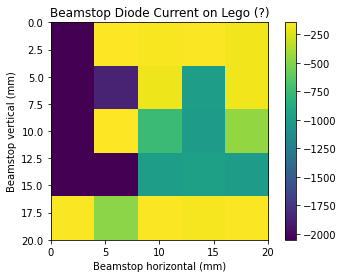

In [135]:
# Plot the results

header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(5, 5)

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

In [62]:
# Finer scan

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20, 21, snake_axes = True))

('54784c8a-5dc7-4e34-8fc5-4dd8634794f4',)

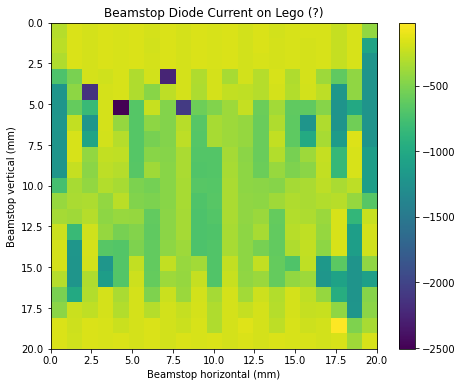

In [65]:
# Plot the results

header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)

plt.figure(figsize=(8,6))

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

In [68]:
# We can try the same scan on Finch, but currently we are not able to access the data. 

# Does turning off snake_axes help to resolve the stripy pattern?

RE(grid_scan([beamstop_diode], sample_x_mm, 10, 20, 21, sample_y_mm, 10, 20, 21, snake_axes = False))

('6bcb10b8-7066-454d-befc-472500887ca4',)

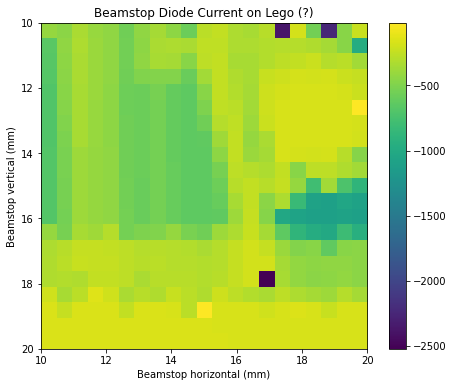

In [ ]:
# Plot the results

header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)

plt.figure(figsize=(8,6))

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

## Spectroscopic scan

In [96]:
# Print current energy and other parameters

def print_current_energy_eV():
    """
    Print the current energy and monochromator angle.
    """
    current_mono = epics.caget('bl531_xps1:mono_angle_deg')
    current_energy = np.round(energy_eV(current_mono), 1)
    print(f'Mono angle: {current_mono:.3f} deg')
    print(f'Current energy: {current_energy} eV')
    
print_current_energy_eV()

print(f'\nMonochromator settle time is set to be: {mono_angle_deg.settle_time} s')

Mono angle: 26.486 deg
Current energy: 8350.0 eV

Monochromator settle time is set to be: 0.0 s


In [120]:
# Set new energy

def set_energy_eV(new_energy):
    """
    Set a new energy by adjusting the monochromator angle.
    
    Parameters:
    -----------
    new_energy : float
        Desired energy in eV.
    """
    new_mono = mono_deg(new_energy)
    epics.caput('bl531_xps1:mono_angle_deg', new_mono)
    time_sleep(5)       # wait for the mono to settle
    print_current_energy_eV()

set_energy_eV(8500)

# Set new mono_angle_deg.settle_time

mono_angle_deg.settle_time = 0.5
print(f'\nMonochromator settle time is set to be: {mono_angle_deg.settle_time} s')

Mono angle: 26.239 deg
Current energy: 8500.0 eV

Monochromator settle time is set to be: 0.5 s


Mono angle: 24.801 deg
Current energy: 9500.0 eV


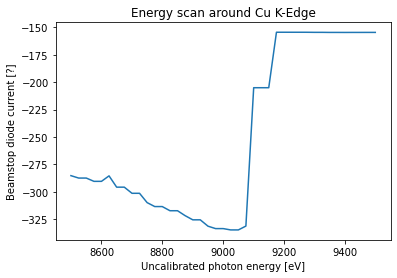

In [104]:
# Energy scan with mono_angle_deg.settle_time = 0.5

E_eV_low = 8500             # low energy in eV
E_eV_high = 9500            # high energy in eV
N_e = 41                    # number of energy points

Es_eV = np.linspace(E_eV_low, E_eV_high, N_e) 
thetas_deg = mono_deg(Es_eV)    # Create a list for scan

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg))

print_current_energy_eV()

a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d = a['beamstop diode'].to_numpy()

plt.plot(energy_eV(t), d)
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('Uncalibrated photon energy [eV]')
plt.ylabel('Beamstop diode current [?]')
plt.show()

In [121]:
# Zoom in around Cu K-edge; Compare forward and backward scans

E_eV_low = 8800             # low energy in eV
E_eV_high = 9300            # high energy in eV
N_e = 51                    # number of energy points

Es_eV_forward = np.linspace(E_eV_low, E_eV_high, N_e) 
thetas_deg_forward = mono_deg(Es_eV_forward) 
Es_eV_backward = np.linspace(E_eV_high, E_eV_low, N_e) 
thetas_deg_backward = mono_deg(Es_eV_backward) 

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))
a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward = a['beamstop diode'].to_numpy()

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_backward))
a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_backward = a['beamstop diode'].to_numpy()

print_current_energy_eV()

Mono angle: 25.773 deg
Current energy: 8800.0 eV


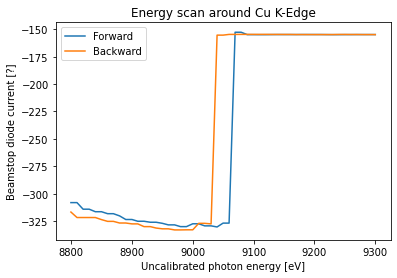

In [122]:
# Plot the results

plt.plot(energy_eV(t), d_forward[::-1], label='Forward')
plt.plot(energy_eV(t), d_backward, label='Backward')
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('Uncalibrated photon energy [eV]')
plt.ylabel('Beamstop diode current [?]')
plt.legend()
plt.show()

In [123]:
mono_angle_deg.settle_time = 2

E_eV_low = 8900             # low energy in eV
E_eV_high = 9200            # high energy in eV
N_e = 121                    # number of energy points

Es_eV_forward = np.linspace(E_eV_low, E_eV_high, N_e) 
thetas_deg_forward = mono_deg(Es_eV_forward) 
Es_eV_backward = np.linspace(E_eV_high, E_eV_low, N_e)
thetas_deg_backward = mono_deg(Es_eV_backward) 

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))
a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_1 = a['beamstop diode'].to_numpy()

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_backward))
a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_backward_1 = a['beamstop diode'].to_numpy()

RE(list_scan([beamstop_diode], mono_angle_deg, thetas_deg_forward))
a = db[-1].table()
t = a['mono angle [deg]'].to_numpy()
d_forward_2 = a['beamstop diode'].to_numpy()


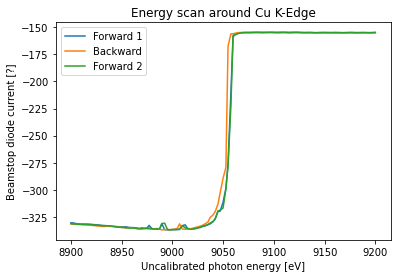

In [128]:
# Plot the results

plt.plot(energy_eV(t), d_forward_1, label='Forward 1')
plt.plot(energy_eV(t), d_backward_1[::-1], label='Backward')
plt.plot(energy_eV(t), d_forward_2, label='Forward 2')
plt.title('Energy scan around Cu K-Edge')
plt.xlabel('Uncalibrated photon energy [eV]')
plt.ylabel('Beamstop diode current [?]')
plt.legend()
plt.show()

## Sample stage scan, with Pilatus detector

__Summary (by Francis, June 26 5 pm)__

With Gabriel's help, so far we have two main solutions:
1. Find the .tif files, which are generated by the adl, under a customized folder with a customized name. 
2. Without knowing any customized filename or pathname, locate the raw .h5 file. 

The second is preferred, for now. 


#### Solution 1: .TIF

In [ ]:
import ophyd
from bluesky.callbacks import CallbackBase
import glob
import os
from datetime import datetime
import threading
import time

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

class OrderedLiveTable(CallbackBase):
    def __init__(self):
        self.monitoring = False
        self.start_time = None
        self.scan_points = []
        self.files_before_scan = set()
        self.displayed_points = set()  # Track which points we've already displayed
        
    def start(self, doc):
        # Capture files that exist BEFORE scan starts
        self.files_before_scan = set(glob.glob("/mnt/data531/*alien*.tif"))
        
        self.start_time = datetime.now()
        self.monitoring = True
        self.scan_points = []
        self.displayed_points = set()
        
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'Full Path':<50}")
        print("-" * 90)
        threading.Thread(target=self._watch, daemon=True).start()
    
    def event(self, doc):
        """Store each scan point as it happens"""
        point_info = {
            'point_num': doc['seq_num'],
            'x_pos': doc['data'].get('sample stage horizontal', 0),
            'y_pos': doc['data'].get('sample stage vertical', 0),
            'event_time': time.time(),
            'file_matched': False,
            'file_path': None
        }
        self.scan_points.append(point_info)
    
    def _watch(self):
        """Monitor and display files as they're detected"""
        while self.monitoring:
            try:
                # Get all current scan files
                current_files = set(glob.glob("/mnt/data531/*alien*.tif"))
                scan_files = sorted(current_files - self.files_before_scan)
                
                # Check if we have new files to display
                for i, file_path in enumerate(scan_files):
                    point_index = i  # File index matches point index
                    
                    if (point_index < len(self.scan_points) and 
                        point_index not in self.displayed_points):
                        
                        # Match file to corresponding scan point
                        point = self.scan_points[point_index]
                        point['file_matched'] = True
                        point['file_path'] = file_path
                        
                        # Display immediately
                        current_time = datetime.now().strftime('%H:%M:%S')
                        print(f"{point['point_num']:<6} "
                              f"{point['x_pos']:<8.3f} "
                              f"{point['y_pos']:<8.3f} "
                              f"{current_time:<10} "
                              f"{file_path:<50}")
                        
                        self.displayed_points.add(point_index)
                        
                time.sleep(0.1)
                
            except Exception as e:
                continue
    
    def stop(self, doc):
        """Final cleanup and ensure all files are matched"""
        print(f"\nScan finished, doing final file matching...")
        
        time.sleep(2)  # Wait for any final files
        
        # Get final list of all scan files
        final_files = set(glob.glob("/mnt/data531/*alien*.tif"))
        scan_files = sorted(final_files - self.files_before_scan)
        
        print(f"DEBUG: Files before scan: {len(self.files_before_scan)}")
        print(f"DEBUG: Files after scan: {len(final_files)}")
        print(f"DEBUG: New files during scan: {len(scan_files)}")
        
        # Match remaining files to points that weren't displayed live
        for i, file_path in enumerate(scan_files):
            if i < len(self.scan_points):
                point = self.scan_points[i]
                point['file_matched'] = True
                point['file_path'] = file_path
                
                # Display any points that weren't shown live
                if i not in self.displayed_points:
                    current_time = datetime.now().strftime('%H:%M:%S')
                    print(f"{point['point_num']:<6} "
                          f"{point['x_pos']:<8.3f} "
                          f"{point['y_pos']:<8.3f} "
                          f"{current_time:<10} "
                          f"{file_path:<50}")
        
        self.monitoring = False
        
        print("-" * 90)
        print(f"Scan completed: {len(self.scan_points)} points, {len(scan_files)} files")
        
        # Show final summary with correct file-to-point mapping
        print(f"\nFinal Summary (Correct File-to-Point Mapping):")
        for i, point in enumerate(self.scan_points):
            if i < len(scan_files):
                file_name = os.path.basename(scan_files[i])
                print(f"  Point {point['point_num']}: X={point['x_pos']:.3f}mm, Y={point['y_pos']:.3f}mm -> {file_name}")
            else:
                print(f"  Point {point['point_num']}: X={point['x_pos']:.3f}mm, Y={point['y_pos']:.3f}mm -> NO FILE FOUND")
        
        # Show chronological file list
        print(f"\nFiles created during scan (chronological order):")
        for i, file_path in enumerate(scan_files, 1):
            print(f"  {i}: {os.path.basename(file_path)}")
        
        print("-" * 90)

# Create the live table and run the scan
ordered_table = OrderedLiveTable()

# Running a scan with the pilatus detector using your defined motors
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), ordered_table)

#### Solution 2: .H5

In [ ]:
import ophyd
from bluesky.callbacks import CallbackBase
from datetime import datetime

# Motor definitions for sample positioning
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

class DetectorLiveTable(CallbackBase):
    """Live table showing scan progress with motor positions, filename displayed at end"""
    
    def __init__(self, detector):
        self.detector = detector
        self.scan_points = []
        self.filename = None
        
    def start(self, doc):
        """Initialize scan and print table header"""
        self.scan_points = []
        self.filename = None
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10}")
        print("-" * 40)
    
    def event(self, doc):
        """Process each scan point and display live results"""
        point_num = doc['seq_num']
        x_pos = doc['data'].get('sample stage horizontal', 0)
        y_pos = doc['data'].get('sample stage vertical', 0)
        
        # Get filename from detector IOC (only once since it's the same file)
        if not self.filename:
            try:
                # Method 1: Get full filename from HDF5 plugin
                if hasattr(self.detector, 'hdf1') and hasattr(self.detector.hdf1, 'full_file_name'):
                    self.filename = self.detector.hdf1.full_file_name.get()
                
                # Method 2: Construct filename from HDF5 components
                elif hasattr(self.detector, 'hdf1'):
                    try:
                        file_path = self.detector.hdf1.file_path.get()
                        file_name = self.detector.hdf1.file_name.get()
                        file_number = self.detector.hdf1.file_number.get()
                        template = self.detector.hdf1.file_template.get()
                        
                        if template and file_name:
                            self.filename = template % (file_path, file_name, file_number)
                        else:
                            self.filename = f"{file_path}/{file_name}_{file_number:03d}.h5"
                    except:
                        pass
                
                # Fallback: Generate generic filename
                if not self.filename:
                    self.filename = f"scan_data.h5"
                    
            except Exception as e:
                print(f"Error getting filename: {e}")
                self.filename = "unknown_file.h5"
        
        # Store scan point data
        point_info = {
            'point_num': point_num,
            'x_pos': x_pos,
            'y_pos': y_pos,
            'frame_num': point_num - 1  # HDF5 frames are 0-indexed
        }
        self.scan_points.append(point_info)
        
        # Display live motor positions only
        current_time = datetime.now().strftime('%H:%M:%S')
        print(f"{point_num:<6} {x_pos:<8.3f} {y_pos:<8.3f} {current_time:<10}")
    
    def stop(self, doc):
        """Display scan completion summary with scan description"""
        print("-" * 40)
        print(f"Scan completed: {len(self.scan_points)} points")
        
        # Display scan description and file info
        if self.filename and self.scan_points:
            print(f"\nHDF5 File: {self.filename}")
            
            # Calculate scan parameters
            x_positions = [p['x_pos'] for p in self.scan_points]
            y_positions = [p['y_pos'] for p in self.scan_points]
            x_range = f"{min(x_positions):.1f} to {max(x_positions):.1f} mm"
            y_range = f"{min(y_positions):.1f} to {max(y_positions):.1f} mm"
            
            print(f"Scan type: {len(self.scan_points)}-point grid scan")
            print(f"X range: {x_range}")
            print(f"Y range: {y_range}")
            print(f"Contains {len(self.scan_points)} detector frames (one per scan point)")
            
            # Save file path as global variable for data analysis
            global last_scan_file, last_scan_data
            last_scan_file = self.filename
            last_scan_data = self.scan_points.copy()
            
            print(f"\n📁 File path saved as: 'last_scan_file'")
            print(f"📊 Scan data saved as: 'last_scan_data'")
        
        print("-" * 40)

# Create live table instance
detector_table = DetectorLiveTable(det)

# Run grid scan with live monitoring
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), detector_table)

### Pilatus scans (Run from here)

Run codes from here, after the Set Up section. 

In [ ]:
# Create live table instance
detector_table = DetectorLiveTable(det)

RE(grid_scan([det], sample_x_mm, 0, 1, 2, sample_y_mm, 0, 1, 2, snake_axes = True), detector_table)

In [ ]:
# Load the HDF5 data
with h5py.File(last_scan_file, 'r') as f:
    # Load all the image data
    images = f['entry/data/data'][:]
    
print(f"📊 Loaded data from: {last_scan_file}")
print(f"   Shape: {images.shape}")

In [ ]:
# Get unique motor positions
x_positions = [point['x_pos'] for point in last_scan_data]
y_positions = [point['y_pos'] for point in last_scan_data]

unique_x = sorted(list(set(x_positions)))
unique_y = sorted(list(set(y_positions)))

num_x = len(unique_x)
num_y = len(unique_y)

# Create subplot grid
fig, axes = plt.subplots(num_y, num_x, figsize=(3*num_x, 3*num_y))

# Handle single row/column cases
if num_x == 1 and num_y == 1:
    axes = [[axes]]
elif num_x == 1:
    axes = [[ax] for ax in axes]
elif num_y == 1:
    axes = [axes]

# Plot each image in correct grid position
for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    
    frame = images[i]
    
    im = axes[y_idx][x_idx].imshow(frame, cmap='viridis',
                                   vmin=np.percentile(frame, 2),
                                   vmax=np.percentile(frame, 98))
    
    axes[y_idx][x_idx].set_title(f'X={point["x_pos"]:.1f}, Y={point["y_pos"]:.1f}', fontsize=10)
    axes[y_idx][x_idx].axis('off')
    
    plt.colorbar(im, ax=axes[y_idx][x_idx], shrink=0.6)

# Add main title
plt.suptitle(f'Motor Scan Grid: {num_x}×{num_y} positions\n{last_scan_file.split("/")[-1]}', 
             fontsize=12, y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
RE(grid_scan([det], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20, 21, snake_axes = True), detector_table)
# To save time I am doing snake scan

In [ ]:
# Load the HDF5 data
with h5py.File(last_scan_file, 'r') as f:
    # Load all the image data
    images = f['entry/data/data'][:]
    
print(f"📊 Loaded data from: {last_scan_file}")
print(f"   Shape: {images.shape}")

In [ ]:
# Plot data
%matplotlib inline

# Get unique motor positions
x_positions = [point['x_pos'] for point in last_scan_data]
y_positions = [point['y_pos'] for point in last_scan_data]

unique_x = sorted(list(set(x_positions)))
unique_y = sorted(list(set(y_positions)))

num_x = len(unique_x)
num_y = len(unique_y)

# Create subplot grid
fig, axes = plt.subplots(num_y, num_x, figsize=(3*num_x, 3*num_y))

# Handle single row/column cases
if num_x == 1 and num_y == 1:
    axes = [[axes]]
elif num_x == 1:
    axes = [[ax] for ax in axes]
elif num_y == 1:
    axes = [axes]

# Plot each image in correct grid position
for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    
    frame = images[i]
    
    im = axes[y_idx][x_idx].imshow(frame, cmap='viridis',
                                   vmin=np.percentile(frame, 2),
                                   vmax=np.percentile(frame, 98))
    
    axes[y_idx][x_idx].set_title(f'X={point["x_pos"]:.1f}, Y={point["y_pos"]:.1f}', fontsize=10)
    axes[y_idx][x_idx].axis('off')
    
    plt.colorbar(im, ax=axes[y_idx][x_idx], shrink=0.6)

# Add main title
plt.suptitle(f'Motor Scan Grid: {num_x}×{num_y} positions\n{last_scan_file.split("/")[-1]}', 
             fontsize=12, y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

# Calculate sum intensity for each frame
intensities = [np.sum(frame) for frame in images]

intensity_grid = np.zeros((len(unique_y), len(unique_x)))

for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    intensity_grid[y_idx, x_idx] = intensities[i]

# Plot STXM map
plt.figure(figsize=(8, 6))
im = plt.imshow(intensity_grid, cmap='viridis', aspect='auto')
plt.title(f'STXM Intensity Map ({len(unique_x)}×{len(unique_y)} grid)', fontsize=14)
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')

# Add position labels
plt.xticks(range(len(unique_x)), [f'{x:.1f}' for x in unique_x])
plt.yticks(range(len(unique_y)), [f'{y:.1f}' for y in unique_y])

plt.colorbar(im, label='Total Intensity')
plt.tight_layout()
plt.show()

In [11]:
# Connect to Pilatus detector

import ophyd
import os
import numpy as np
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34
from ophyd import EpicsSignalRO

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            # Convert to numpy array and filter out null terminators and zeros
            arr = np.array(ascii_array)
            # Remove null terminators (0) and convert to characters
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

# Test file path and file information retrieval
print("\n🔍 Testing file path and file information access...")

# File information PVs for this detector (using actual prefix)
file_path_pv = '13PIL1:cam1:FilePath_RBV'          # Current file path
file_name_pv = '13PIL1:cam1:FileName_RBV'          # Current file name  
file_number_pv = '13PIL1:cam1:FileNumber_RBV'      # Current file number
file_template_pv = '13PIL1:cam1:FileTemplate_RBV'  # File naming template
full_filename_pv = '13PIL1:cam1:FullFileName_RBV'  # Complete file path+name
# For HDF5 plugin:
hdf5_filename_pv = '13PIL1:HDF1:FullFileName_RBV'  # HDF5 plugin file info

# Create EPICS signals to read these PVs
try:
    file_path_signal = EpicsSignalRO(file_path_pv, name='file_path')
    file_name_signal = EpicsSignalRO(file_name_pv, name='file_name')
    file_number_signal = EpicsSignalRO(file_number_pv, name='file_number')
    file_template_signal = EpicsSignalRO(file_template_pv, name='file_template')
    full_filename_signal = EpicsSignalRO(full_filename_pv, name='full_filename')
    hdf5_filename_signal = EpicsSignalRO(hdf5_filename_pv, name='hdf5_filename')
    
    # Wait for connections
    import time
    time.sleep(1)
    
    # Read and display current values (converted to strings)
    file_path_raw = file_path_signal.get()
    file_name_raw = file_name_signal.get()
    file_template_raw = file_template_signal.get()
    full_filename_raw = full_filename_signal.get()
    hdf5_filename_raw = hdf5_filename_signal.get()
    
    print(f"📁 Current file path: '{ascii_array_to_string(file_path_raw)}'")
    print(f"📄 Current file name: '{ascii_array_to_string(file_name_raw)}'")
    print(f"🔢 Current file number: {file_number_signal.get()}")
    print(f"📝 File template: '{ascii_array_to_string(file_template_raw)}'")
    print(f"🗂️  Full filename (cam): '{ascii_array_to_string(full_filename_raw)}'")
    print(f"🗂️  Full filename (HDF5): '{ascii_array_to_string(hdf5_filename_raw)}'")
    
    # Also check if we can access through the detector object
    print(f"\n📋 Via detector object:")
    if hasattr(det.cam, 'file_path'):
        print(f"   File path: {det.cam.file_path.get()}")
    if hasattr(det.cam, 'file_name'):
        print(f"   File name: {det.cam.file_name.get()}")
    if hasattr(det.hdf1, 'file_path'):
        print(f"   HDF5 file path: {det.hdf1.file_path.get()}")
    if hasattr(det.hdf1, 'file_name'):
        print(f"   HDF5 file name: {det.hdf1.file_name.get()}")
        
    # Decode the information we got
    print(f"\n🔍 Decoded information:")
    current_path = ascii_array_to_string(file_path_raw)
    current_name = ascii_array_to_string(file_name_raw)
    current_template = ascii_array_to_string(file_template_raw)
    current_full = ascii_array_to_string(full_filename_raw)
    
    print(f"   Camera is currently set to save files at: {current_path}")
    print(f"   Base filename: {current_name}")
    print(f"   Template: {current_template}")
    print(f"   Next file will be: {current_full}")
        
except Exception as e:
    print(f"❌ Error accessing file information: {e}")
    print("   This might be normal if the detector is not connected or PV names are different")

print("\n✅ File information test completed!")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s

🔍 Testing file path and file information access...
📁 Current file path: '/mnt/data531/'
📄 Current file name: '20250630_alien'
🔢 Current file number: 12
📝 File template: '%s%s%03i.tif'
🗂️  Full filename (cam): '/mnt/data531/20250630_alien011.tif'
🗂️  Full filename (HDF5): ''

📋 Via detector object:
   HDF5 file path: /mnt/data531/test/pilatus/2025/06/30/
   HDF5 file name: 6df231c6-5176-4b79-a33e

🔍 Decoded information:
   Camera is currently set to save files at: /mnt/data531/
   Base filename: 20250630_alien
   Template: %s%s%03i.tif
   Next file will be: /mnt/data531/20250630_alien011.tif

✅ File information test completed!


In [12]:
import ophyd
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np
from datetime import datetime

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class SimpleLiveTable(CallbackBase):
    def __init__(self, detector):
        self.detector = detector
        # Create EPICS signal to read the full filename directly from detector
        self.full_filename_signal = EpicsSignalRO('13PIL1:cam1:FullFileName_RBV', name='full_filename')
        
    def start(self, doc):
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'Image File':<60}")
        print("-" * 100)
        
    def event(self, doc):
        """Display each scan point with its corresponding image file"""
        try:
            # Get current position data
            point_num = doc['seq_num']
            x_pos = doc['data'].get('sample stage horizontal', 0)
            y_pos = doc['data'].get('sample stage vertical', 0)
            current_time = datetime.now().strftime('%H:%M:%S')
            
            # Get the current filename directly from the detector
            # Option 1: Try to get from detector object
            try:
                if hasattr(self.detector.cam, 'full_file_name'):
                    full_path = self.detector.cam.full_file_name.get()
                elif hasattr(self.detector.hdf1, 'full_file_name'):
                    full_path = self.detector.hdf1.full_file_name.get()
                else:
                    # Option 2: Use the EPICS signal directly
                    full_path_raw = self.full_filename_signal.get()
                    full_path = ascii_array_to_string(full_path_raw)
            except:
                # Option 3: Construct from available information
                try:
                    file_path_raw = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='path').get()
                    file_name_raw = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='name').get()
                    file_number = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='number').get()
                    
                    path = ascii_array_to_string(file_path_raw)
                    name = ascii_array_to_string(file_name_raw)
                    full_path = f"{path}{name}{file_number:03d}.tif"
                except:
                    full_path = "Unable to determine file path"
            
            # Display the information
            print(f"{point_num:<6} "
                  f"{x_pos:<8.3f} "
                  f"{y_pos:<8.3f} "
                  f"{current_time:<10} "
                  f"{full_path:<60}")
                  
        except Exception as e:
            print(f"Error in event callback: {e}")
    
    def stop(self, doc):
        print("-" * 100)
        print("Scan completed!")

# Even simpler version - just using detector's built-in file tracking
class UltraSimpleLiveTable(CallbackBase):
    def __init__(self):
        pass
        
    def start(self, doc):
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'File Info':<50}")
        print("-" * 90)
        
    def event(self, doc):
        """Display each scan point - let the detector handle file info"""
        point_num = doc['seq_num']
        x_pos = doc['data'].get('sample stage horizontal', 0)
        y_pos = doc['data'].get('sample stage vertical', 0)
        current_time = datetime.now().strftime('%H:%M:%S')
        
        # Get file info from detector readings in the event document
        file_info = "Image captured"
        
        # If the detector stores file info in the event document, use it
        if 'det' in doc['data']:
            file_info = f"Detector reading: {doc['data']['det']}"
        
        # Try to get the current file number from the detector
        try:
            file_num_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            current_file_num = file_num_signal.get()
            file_info = f"File #{current_file_num}"
        except:
            pass
            
        print(f"{point_num:<6} "
              f"{x_pos:<8.3f} "
              f"{y_pos:<8.3f} "
              f"{current_time:<10} "
              f"{file_info:<50}")
    
    def stop(self, doc):
        print("-" * 90)
        print("Scan completed!")
        
        # Print final file information summary
        try:
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='final_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='final_name')
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='final_number')
            
            import time
            time.sleep(0.5)  # Brief wait for final values
            
            final_path = ascii_array_to_string(file_path_signal.get())
            final_name = ascii_array_to_string(file_name_signal.get())
            final_number = file_number_signal.get()
            
            print(f"\nFinal detector state:")
            print(f"  File path: {final_path}")
            print(f"  Base name: {final_name}")
            print(f"  Next file number: {final_number}")
            print(f"  Last file would be: {final_path}{final_name}{final_number-1:03d}.tif")
            
        except Exception as e:
            print(f"Could not retrieve final file info: {e}")

# Create the simple live table and run the scan
print("Using Ultra Simple Live Table (recommended):")
simple_table = UltraSimpleLiveTable()

# Running a scan with the pilatus detector using your defined motors
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=True), simple_table)

Using Ultra Simple Live Table (recommended):

Point  X_mm     Y_mm     Time       File Info                                         
------------------------------------------------------------------------------------------
1      0.000    0.000    16:29:38   File #13                                          
2      0.000    2.000    16:29:57   File #14                                          
3      2.000    2.000    16:30:15   File #15                                          
4      2.000    0.000    16:30:34   File #16                                          
------------------------------------------------------------------------------------------
Scan completed!

Final detector state:
  File path: /mnt/data531/
  Base name: 20250630_alien
  Next file number: 16
  Last file would be: /mnt/data531/20250630_alien015.tif


('b57e3f3c-37dc-40d6-b374-6b58f03a60cd',)

In [ ]:
a